# Imports

In [122]:
import csv

import numpy as np
import pandas as pd
import scipy.signal
import astropy.stats

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

# Constants

##### J1311 coords

- PSR J1311-3430 -- Pulsar
- Other object types:	gam (3EG,0FGL,...), Psr (PSR)
- ICRS coord. (ep=J2000) :	13 11 50.2 -34 30 07 (Gamma-ray) [ 79200 79200 -20 ] E 2015ApJS..218...23A

- [source](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PSR%20J1311-34300)

In [13]:
# Physical constants
pi = 3.14159

In [14]:
# Plot text sizes
title_size = 24
axislabel_size = 22
axistick_size = 20

# File IO
- J1311 part 1 had error with additional 'E' inserted into line 40
- J1311 part 1 had additional column 'EVENT ID' that was removed.

##### Get file paths

- *** Change 'file_directory' for your computer! ***

In [73]:
file_path = '/home/family/Documents/black_widow/lc/J1311_test_mk_file.txt'
print file_path

/home/family/Documents/black_widow/lc/J1311_test_mk_file.txt


##### Load pandas df
- Adjust the header to be pandas conformant... Pandas doesn't like underscores for some reason.

In [74]:
fh = open(file_path)
header = ' '.join(fh.read().split('\n')[0].split()).split(' ')
header = [ele.replace('_', ' ') for ele in header]
print header
fh.close()

['Energy', 'Ra', 'Dec', 'Time', 'Pulse Phase']


- Create pandas df from every file

In [75]:
df = pd.read_csv(file_path, skiprows = [0], delimiter = ' ', names = header)
df = pd.concat([df, pd.read_csv(file_path, skiprows = [0], delimiter = ' ', names = [ele for ele in header if ele != 'EVENT ID'])], axis = 0)
print len(df)

361168


In [76]:
df.head()

,Energy,Ra,Dec,Time,Pulse Phase
0,1449.0700,192.2922,-35.34074,2.395811e+08,0.189888
1,640.5836,192.6592,-36.01581,2.395869e+08,0.712124
2,105.1906,192.7956,-35.55548,2.397024e+08,0.647053
3,149.2639,195.6846,-31.98225,2.395877e+08,0.994099
4,1623.7720,197.2992,-32.45776,2.396110e+08,0.853184


In [77]:
print df.dtypes

Energy         float64
Ra             float64
Dec            float64
Time           float64
Pulse Phase    float64
dtype: object


##### Inspect columns

In [78]:
df.describe()

,Energy,Ra,Dec,Time,Pulse Phase
count,361168.000000,361168.000000,361168.000000,3.611680e+05,361168.000000
mean,634.191650,197.940142,-34.579675,3.670900e+08,0.498594
std,2323.286169,2.897222,2.426730,7.500604e+07,0.288977
min,100.000400,191.889100,-39.482250,2.395596e+08,0.000000
25%,158.149775,195.674800,-36.498002,3.012087e+08,0.248287
50%,262.752700,197.958300,-34.520120,3.668381e+08,0.496581
75%,531.424300,200.148025,-32.727360,4.327856e+08,0.749359
max,279906.300000,204.025300,-29.483690,4.941394e+08,0.999996


##### Visualization
- Bin the photons into right ascension and declination coordinate bins, creating a 2-D histogram (matrix)
- Create a ROI and plot on top of matrix; eventually we will remove all photons outside of the ROI

In [79]:
ra = df['Ra'].values
dec = df['Dec'].values
log_energy = np.log(df['Energy'].values)

ra_bins = np.linspace(np.min(ra), np.max(ra), 1024)

dec_bins = np.linspace(np.min(dec), np.max(dec), 1024)

ra_binned = np.digitize(ra, ra_bins) - 1
dec_binned = np.digitize(dec, dec_bins) - 1

dec_ra_matrix = np.zeros((dec_bins.shape[0], ra_bins.shape[0]))

for i in range(len(df)):
    dec_ra_matrix[dec_binned[i], ra_binned[i]] += 1

In [117]:
# Define the ROI ellipse. Center coordinates should come from official coords.
ra_center = 197.958174
dec_center = -34.48289977


# a, b are the two axes of the ellipse ROI
a1 = 1
b1 = 1


thetas = np.linspace(0, 2*pi, 100)
ras = np.digitize(ra_center + a1*np.cos(thetas), ra_bins)
decs = np.digitize(dec_center + b1*np.sin(thetas), dec_bins)

#new size

a2 = 0.5
b2 = 0.5


thetas = np.linspace(0, 2*pi, 100)
ras_new = np.digitize(ra_center + a2*np.cos(thetas), ra_bins)
decs_new = np.digitize(dec_center + b2*np.sin(thetas), dec_bins)


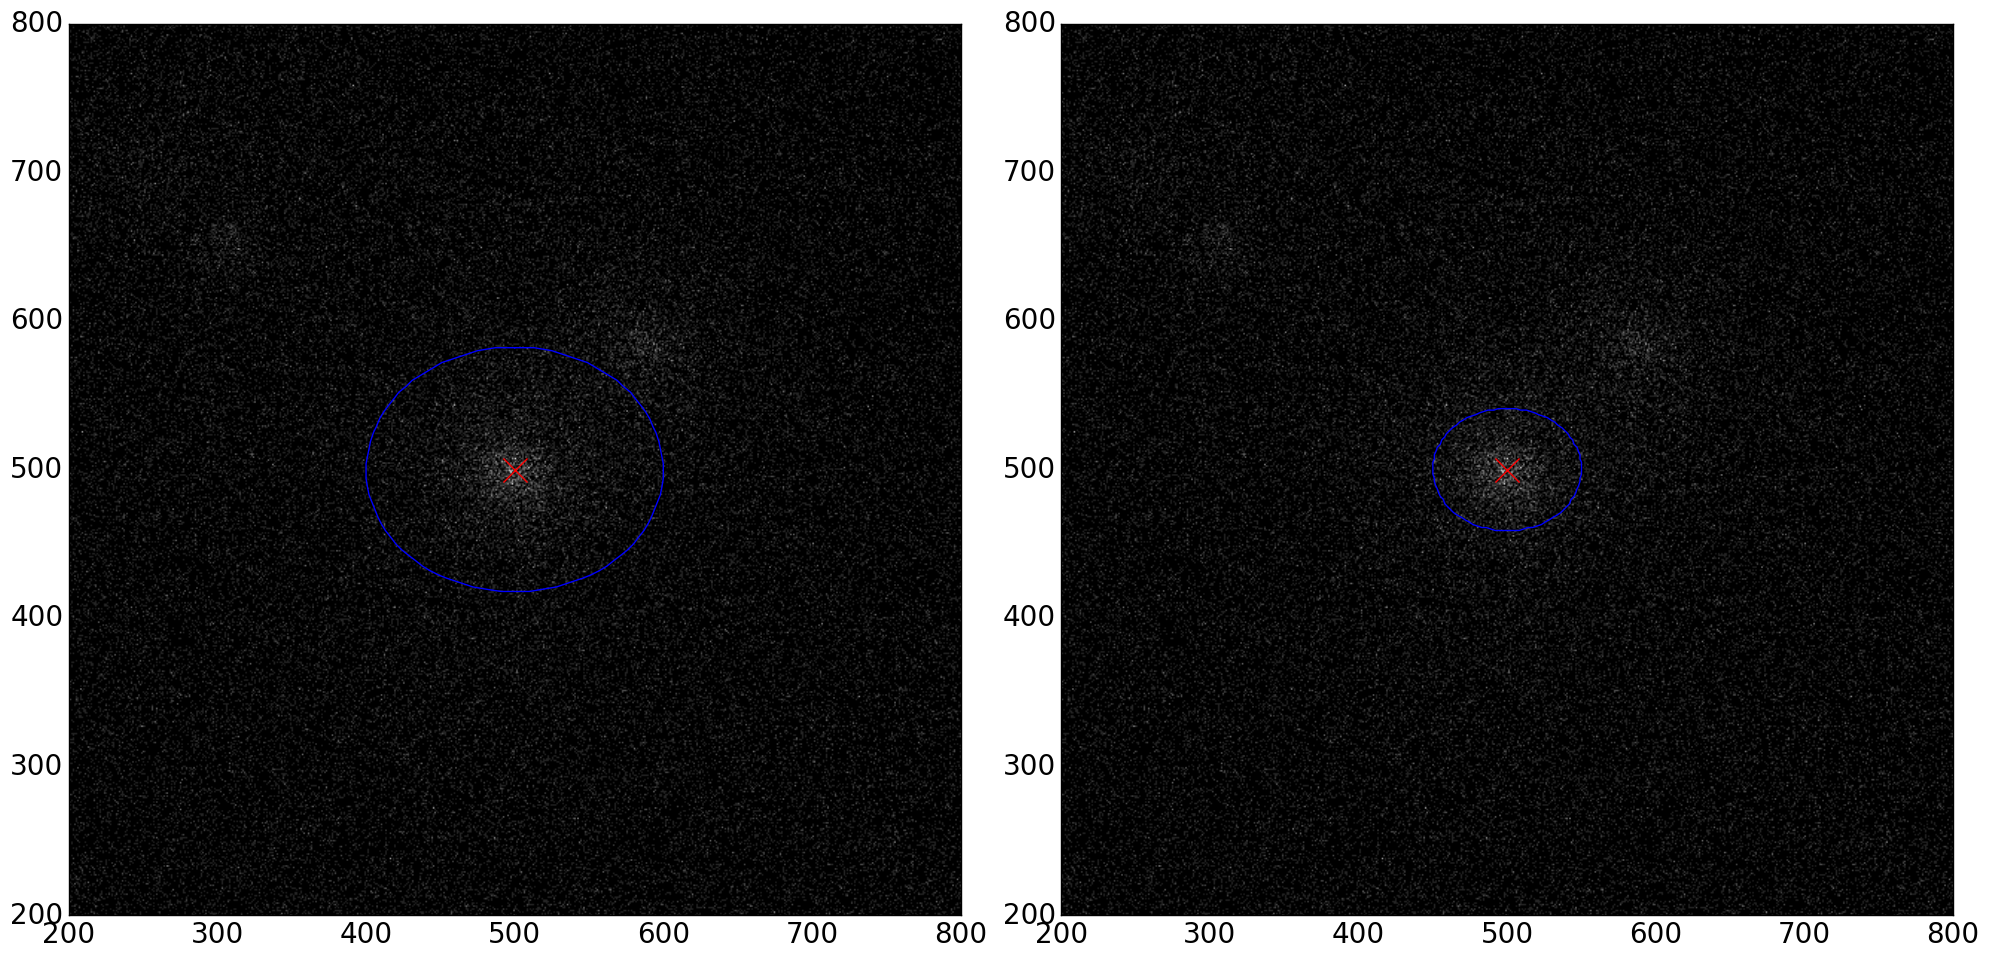

In [116]:
# Plot matrix and ROI ellipse
fig, ax = plt.subplots(1, 2, figsize = (20,10))

fig.sca(ax[0])
plt.imshow(dec_ra_matrix, cmap = 'gray', origin = 'lower left')                 # Photon matrix
plt.plot(decs, ras)                                                             # ROI boundary
plt.scatter(np.digitize(dec_center, dec_bins),                                  # Center of ROI marker
            np.digitize(ra_center, ra_bins),
            s = 300, marker = 'x', color = 'red') 


plt.xlim(200,800)
plt.ylim(200,800)

plt.tick_params(labelsize = axistick_size)

fig.sca(ax[1])
plt.imshow(dec_ra_matrix, cmap = 'gray', origin = 'lower left')                 # Photon matrix
plt.plot(decs_new, ras_new)                                                             # ROI boundary
plt.scatter(np.digitize(dec_center, dec_bins),                                  # Center of ROI marker
            np.digitize(ra_center, ra_bins),
            s = 300, marker = 'x', color = 'red') 


plt.xlim(200,800)
plt.ylim(200,800)

plt.tick_params(labelsize = axistick_size)

fig.tight_layout()

plt.show()



##### Create a new df with all elements that are outside the ROI dropped

In [118]:
mod_df = df[df['Ra'].map(lambda x: (x-ra_center)**2.)/a1**2.+df['Dec'].map(lambda y: (y-dec_center)**2.)/b1**2. <= 1]

mod_df_new=df[df['Ra'].map(lambda x: (x-ra_center)**2.)/a2**2.+df['Dec'].map(lambda y: (y-dec_center)**2.)/b2**2. <= 1]

In [119]:
print len(df)
print len(mod_df)
print len(mod_df_new)

361168
23496
9172


##### remove high energy points from outside even smaller ROI

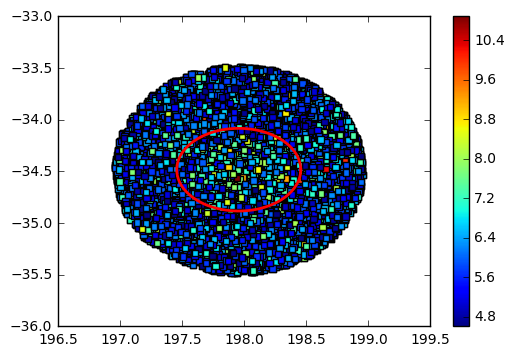

In [165]:
#colour map
ra = mod_df['Ra'].values
dec = mod_df['Dec'].values
log_energy = np.log(mod_df['Energy'].values)

plt.scatter(ra,dec, c=log_energy, marker='s')
plt.colorbar()

a1=0.50
b1=0.40
thetas = np.linspace(0, 2*pi, 100)
ras = (ra_center + a1*np.cos(thetas))
decs = (dec_center + b1*np.sin(thetas))
plt.plot(ras, decs, 'r', linewidth=2.0)

In [172]:
a1=0.50
b1=0.40

circle=mod_df[mod_df['Ra'].map(lambda x: (x-ra_center)**2.)/a1**2.+mod_df['Dec'].map(lambda y: (y-dec_center)**2.)/b1**2. <= 1]

#df_ra=mod_df[mod_df['Ra']>ras]
#df_highe = mod_df[log_energy > 8.8, and mod_df['Ra'].value>ras and mod_df['Dec'].value>decs]

#modE_df=mod_df[]
#circle.describe()

##### Plot

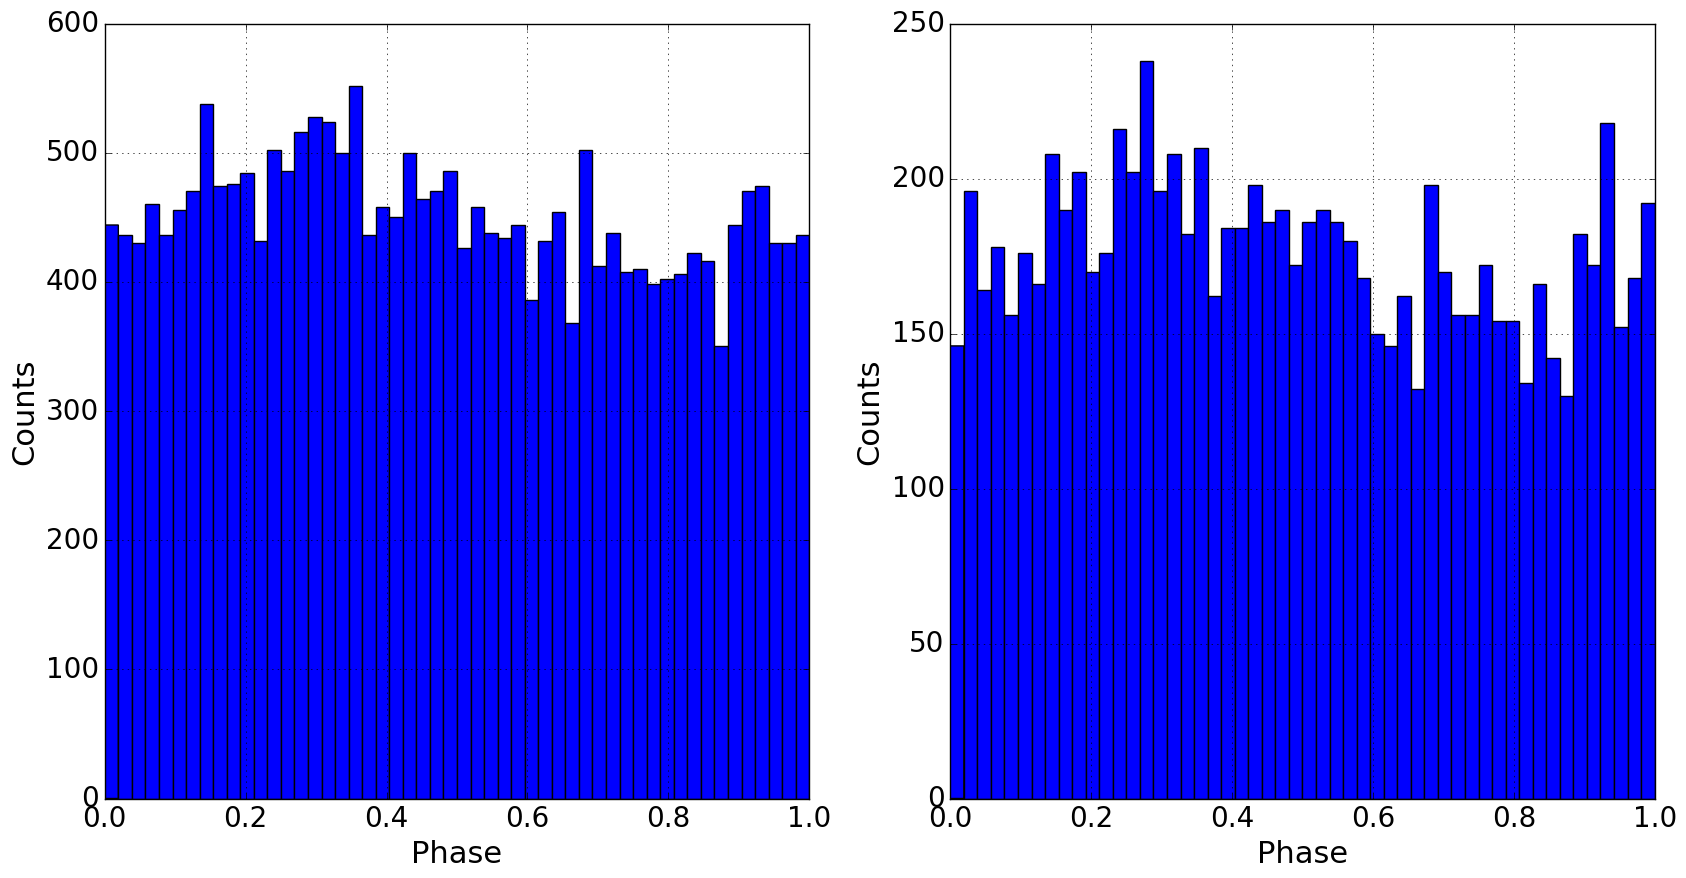

In [120]:
fig, his = plt.subplots(1, 2, figsize = (20,10))

fig.sca(his[0])
plt.hist(mod_df['Pulse Phase'], bins = 52)
#plt.ylim(4000, 4500)

plt.xlabel('Phase', size = axislabel_size)
plt.ylabel('Counts', size = axislabel_size)

plt.grid()
plt.tick_params(labelsize = axistick_size)

fig.sca(his[1])
plt.hist(mod_df_new['Pulse Phase'], bins = 52)
#plt.ylim(4000, 4500)

plt.xlabel('Phase', size = axislabel_size)
plt.ylabel('Counts', size = axislabel_size)

plt.grid()
plt.tick_params(labelsize = axistick_size)


plt.show()

phase_cutoff = .5
df = df[df['PULSE PHASE'] < phase_cutoff]

# Extra

##### plot region of sky density

### Ra, Dec, 


In [85]:
ra = df['Ra'].values
dec = df['Dec'].values


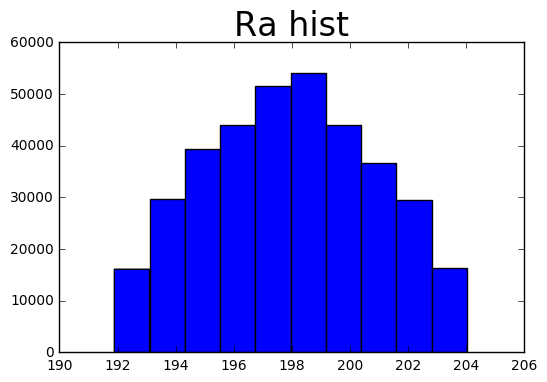

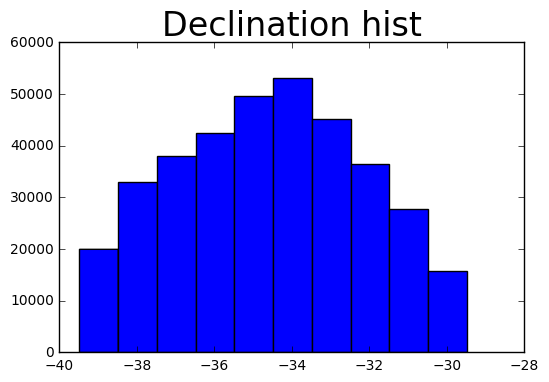

In [86]:
plt.hist(ra)

plt.title('Ra hist', size = title_size)
plt.show()

plt.hist(dec)

plt.title('Declination hist', size = title_size)
plt.show()


In [87]:
ra_bins = np.linspace(np.min(ra), np.max(ra), 1000)
min_ra = np.min(ra)

dec_bins = np.linspace(np.min(dec), np.max(dec), 1000)
min_dec = np.min(dec)

ra_binned = np.digitize(ra, ra_bins) - 1
dec_binned = np.digitize(dec, dec_bins) - 1

dec_ra_matrix = np.zeros((dec_bins.shape[0], ra_bins.shape[0]))

for i in range(len(df)):
  dec_ra_matrix[dec_binned[i], ra_binned[i]] += 1

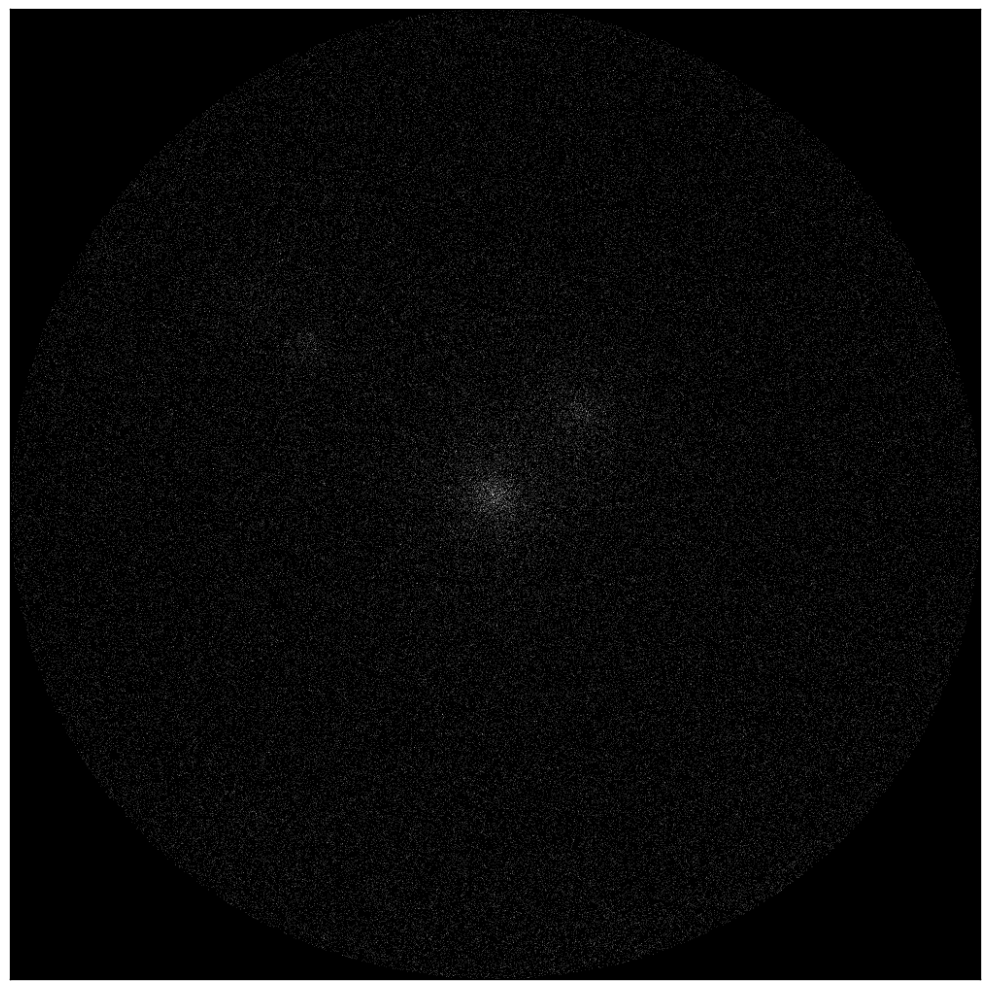

In [88]:
fig = plt.figure(figsize = (10,10))
plt.imshow(dec_ra_matrix, cmap = 'gray', origin = 'lower left')
plt.xticks([])
plt.yticks([])
fig.tight_layout()
#plt.savefig('J1311_photons_4.png', dpi = 300)
plt.show()

### plot phase vs. time

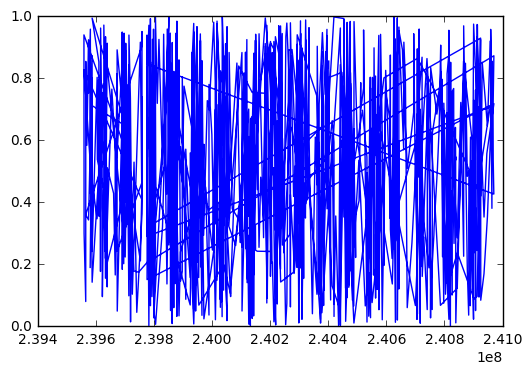

In [89]:
data = df[['Time', 'Pulse Phase']].values[:1000]

plt.plot(data[:,0], data[:,1])
plt.show()

##### Check the PSD of the PULSE PHASE to see if we can see the ms pulsar signal

In [90]:
orbital_freq = 1/(93.8*60)
print orbital_freq

0.000177683013504


In [91]:
data = df[['Time', 'Pulse Phase']].values[:100000]
freq, power = astropy.stats.LombScargle(data[:,0], data[:,1]).autopower()

In [92]:
print np.min(freq), np.max(freq)

6.99691370994e-10 0.00174922772779


In [93]:
min_freq = np.min(freq)
duration = 1./min_freq
print duration/(60*60*24)

16541.6847397


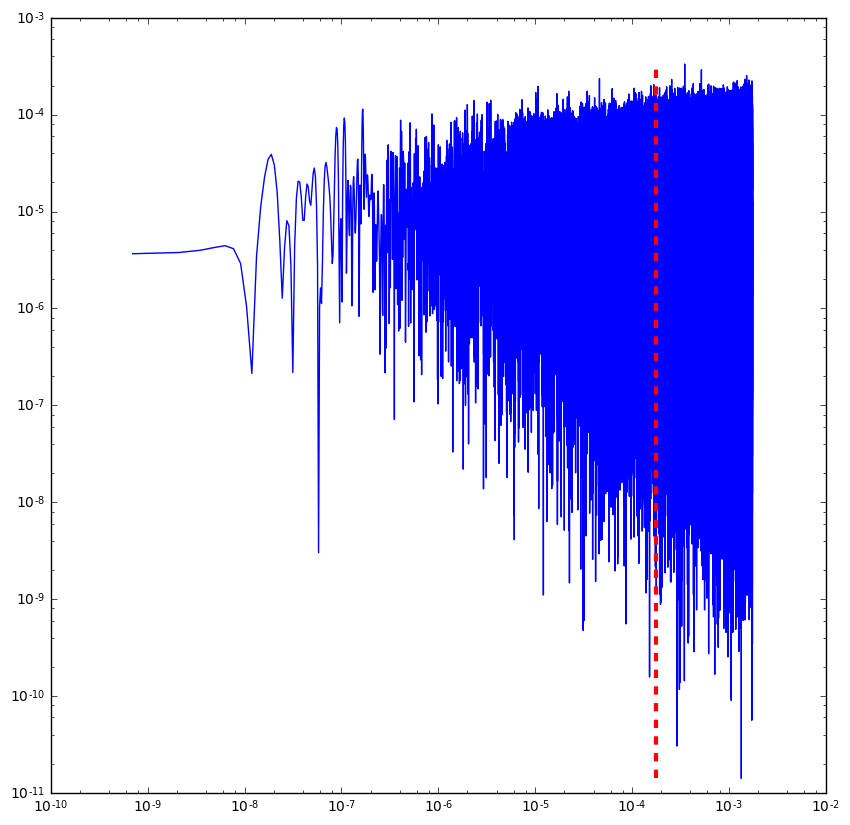

In [94]:
fig = plt.figure(figsize = (10,10))
plt.loglog(freq, power)
plt.plot([orbital_freq, orbital_freq], [np.min(power), np.max(power)], ls = '--', color = 'red', lw = 3)
plt.show()

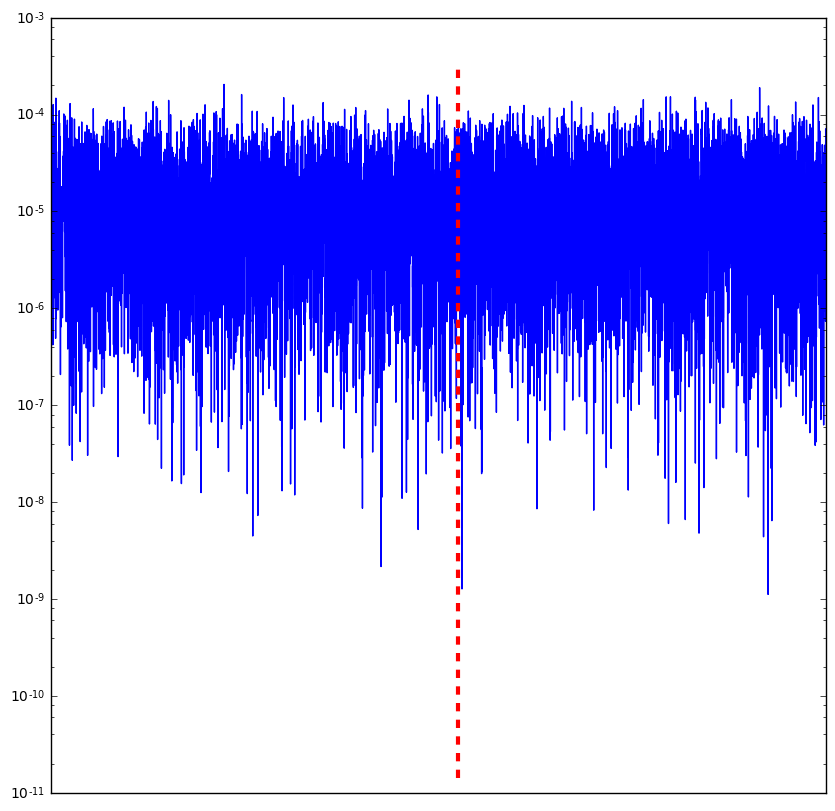

In [95]:
fig = plt.figure(figsize = (10,10))
plt.loglog(freq, power)
plt.plot([orbital_freq, orbital_freq], [np.min(power), np.max(power)], ls = '--', color = 'red', lw = 3)
plt.xlim(orbital_freq*.9, orbital_freq*1.1)
plt.show()